#### First, I figure out the phase/phi of one of the ITM mirrors to set the AS port dark for the carrier.

In [378]:
import finesse
finesse.configure(plotting=True)
prmi=finesse.Model()
prmi.parse("""
l laser P=1
s s0 laser.p1 eom.p1 
mod eom midx=0.4 order=1 f=9M

#PRM
s s1 eom.p2 pr.p1 
m pr R=0.85 T=0.15
s pr_Bs pr.p2 Bs.p1 

bs Bs R=0.5 T=0.5

#X-arm
s Lx Bs.p3 ITMx.p1 
m ITMx R=1 T=0

#Y-arm
s Ly Bs.p2 ITMy.p1
m ITMy R=1 T=0

pd AS_dc Bs.p4.o 
pd REFL_dc pr.p1.o
pd POP_dc pr.p2.o
pd Arm_trans ITMx.p2.o

xaxis(ITMx.phi,lin,-180,180,1000)

""")

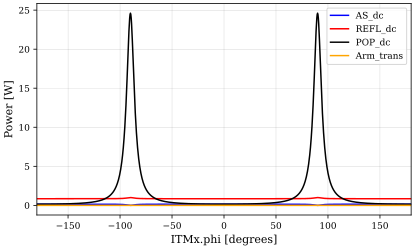

{finesse.detectors.powerdetector.PowerDetector: <Figure size 576x355.968 with 1 Axes>,
 'AS_dc': <Figure size 576x355.968 with 1 Axes>,
 'REFL_dc': <Figure size 576x355.968 with 1 Axes>,
 'POP_dc': <Figure size 576x355.968 with 1 Axes>,
 'Arm_trans': <Figure size 576x355.968 with 1 Axes>}

In [379]:
output=prmi.run()
output.plot()

#### The power buildup in the PRC is maximum when the ITMx is at phi=$\pm 90$ degrees.

In [387]:
prmi2=finesse.Model()
prmi2.parse("""
l laser P=1
s s0 laser.p1 eom.p1 
mod eom midx=0.4 order=1 f=9M

#PRM
s s1 eom.p2 pr.p1 
m pr R=0.85 T=0.15 
s pr_Bs pr.p2 Bs.p1 

bs Bs R=0.5 T=0.5 

#X-arm
s Lx Bs.p3 ITMx.p1 
m ITMx R=0.9 T=0.1 phi=90            #Added that phi to the ITMx

#Y-arm
s Ly Bs.p2 ITMy.p1 
m ITMy R=0.9 T=0.1

ad POP_C pr.p2.o f=0
ad POP_9M pr.p2.o f=9M

pd AS_dc Bs.p4.o 
pd REFL_dc pr.p1.o
pd POP_dc pr.p2.o
pd Arm_trans ITMx.p2.o


xaxis(pr.phi,lin,-180,180,1000)

""")

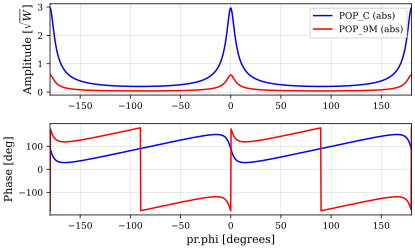

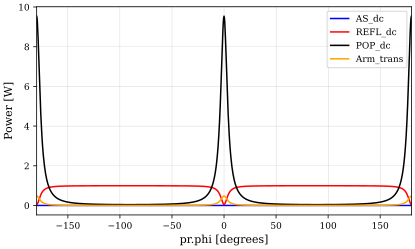

{finesse.detectors.amplitude_detector.AmplitudeDetector: <Figure size 576x355.968 with 2 Axes>,
 'POP_C': <Figure size 576x355.968 with 2 Axes>,
 'POP_9M': <Figure size 576x355.968 with 2 Axes>,
 finesse.detectors.powerdetector.PowerDetector: <Figure size 576x355.968 with 1 Axes>,
 'AS_dc': <Figure size 576x355.968 with 1 Axes>,
 'REFL_dc': <Figure size 576x355.968 with 1 Axes>,
 'POP_dc': <Figure size 576x355.968 with 1 Axes>,
 'Arm_trans': <Figure size 576x355.968 with 1 Axes>}

In [388]:
output=prmi2.run()
output.plot()

#### Adding random PRC length parameters (Lx,Ly,pr-bs)

In [389]:
prmi3=finesse.Model()
prmi3.parse("""
l laser P=1
s s0 laser.p1 eom.p1 
mod eom midx=0.4 order=1 f=9M

#PRM
s s1 eom.p2 pr.p1 
m pr R=0.85 T=0.15 
s pr_Bs pr.p2 Bs.p1 L=3

bs Bs R=0.5 T=0.5 

#X-arm
s Lx Bs.p3 ITMx.p1 L=5
m ITMx R=0.9 T=0.1 phi=90

#Y-arm
s Ly Bs.p2 ITMy.p1 L=5
m ITMy R=0.9 T=0.1

ad POP_C pr.p2.o f=0
ad POP_9M pr.p2.o f=9M
#ad AS_C Bs.p4.o f=0
#ad AS_9M Bs.p4.o f=9M

pd AS_dc Bs.p4.o 
pd REFL_dc pr.p1.o
pd POP_dc pr.p2.o
pd Arm_trans ITMx.p2.o

xaxis(pr.phi,lin,-180,180,1000)

""")

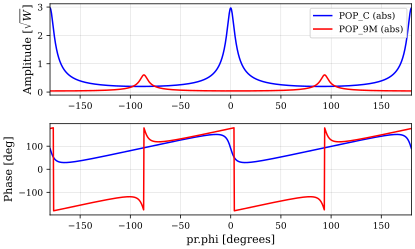

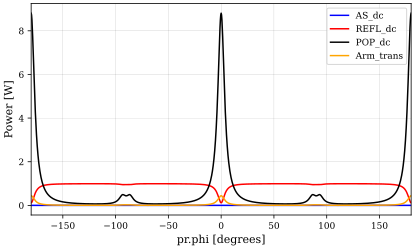

{finesse.detectors.amplitude_detector.AmplitudeDetector: <Figure size 576x355.968 with 2 Axes>,
 'POP_C': <Figure size 576x355.968 with 2 Axes>,
 'POP_9M': <Figure size 576x355.968 with 2 Axes>,
 finesse.detectors.powerdetector.PowerDetector: <Figure size 576x355.968 with 1 Axes>,
 'AS_dc': <Figure size 576x355.968 with 1 Axes>,
 'REFL_dc': <Figure size 576x355.968 with 1 Axes>,
 'POP_dc': <Figure size 576x355.968 with 1 Axes>,
 'Arm_trans': <Figure size 576x355.968 with 1 Axes>}

In [390]:
output=prmi3.run()
output.plot()

#### The macroscopic PRC length changes cannot bring the necessary resonance of SB and Anti-Resonance of C, I am tuning the PRM, where the resonance of SB and anti-resonance of C occurs.

In [392]:
prmi4=finesse.Model()
prmi4.parse("""
l laser P=1
s s0 laser.p1 eom.p1 L=0
mod eom midx=0.4 order=1 f=9M

#PRM
s s1 eom.p2 pr.p1 L=0
m pr R=0.85 T=0.15 phi=93.5          #at phi~93.5, the conditions are met.
s pr_Bs pr.p2 Bs.p1 L=3  

bs Bs R=0.5 T=0.5 

#X-arm
s Lx Bs.p3 ITMx.p1 L=5
m ITMx R=0.9 T=0.1 phi=90

#Y-arm
s Ly Bs.p2 ITMy.p1 L=5
m ITMy R=0.9 T=0.1

#pd AS_dc Bs.p4.o 
#pd REFL_dc pr.p1.o
#pd POP_dc pr.p2.o

ad POP_C pr.p2.o f=0
ad POP_9M pr.p2.o f=9M
ad AS_C Bs.p4.o f=0
ad AS_9M Bs.p4.o f=9M

xaxis(Bs.phi,lin,-180,180,1000)

""")

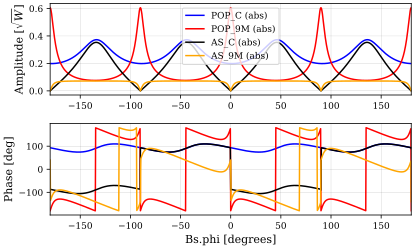

{finesse.detectors.amplitude_detector.AmplitudeDetector: <Figure size 576x355.968 with 2 Axes>,
 'POP_C': <Figure size 576x355.968 with 2 Axes>,
 'POP_9M': <Figure size 576x355.968 with 2 Axes>,
 'AS_C': <Figure size 576x355.968 with 2 Axes>,
 'AS_9M': <Figure size 576x355.968 with 2 Axes>}

In [393]:
output=prmi4.run()
output.plot()

#### Now, I will set the Schnupp asymmetry for allowing SB to the AS port.

In [396]:
prmi5=finesse.Model()
prmi5.parse("""
l laser P=1
s s0 laser.p1 eom.p1 L=0
mod eom midx=0.4 order=1 f=9M

#PRM
s s1 eom.p2 pr.p1 L=0
m pr R=0.85 T=0.15 phi=93.5
s pr_Bs pr.p2 Bs.p1 L=3  

bs Bs R=0.5 T=0.5 

#X-arm
s Lx Bs.p3 ITMx.p1 L=5.1
m ITMx R=0.9 T=0.1 phi=90

#Y-arm
s Ly Bs.p2 ITMy.p1 L=4.9
m ITMy R=0.9 T=0.1

ad POP_C pr.p2.o f=0
ad POP_9M pr.p2.o f=9M
ad AS_C Bs.p4.o f=0
ad AS_9M Bs.p4.o f=9M

pd AS_dc Bs.p4.o 
pd REFL_dc pr.p1.o
pd POP_dc pr.p2.o
pd Arm_trans ITMx.p2.o


xaxis(Bs.phi,lin,-180,180,1000)

""")

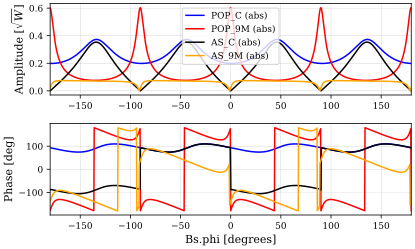

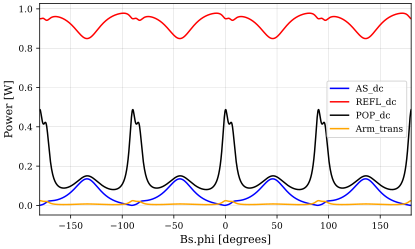

{finesse.detectors.amplitude_detector.AmplitudeDetector: <Figure size 576x355.968 with 2 Axes>,
 'POP_C': <Figure size 576x355.968 with 2 Axes>,
 'POP_9M': <Figure size 576x355.968 with 2 Axes>,
 'AS_C': <Figure size 576x355.968 with 2 Axes>,
 'AS_9M': <Figure size 576x355.968 with 2 Axes>,
 finesse.detectors.powerdetector.PowerDetector: <Figure size 576x355.968 with 1 Axes>,
 'AS_dc': <Figure size 576x355.968 with 1 Axes>,
 'REFL_dc': <Figure size 576x355.968 with 1 Axes>,
 'POP_dc': <Figure size 576x355.968 with 1 Axes>,
 'Arm_trans': <Figure size 576x355.968 with 1 Axes>}

In [397]:
output=prmi5.run()
output.plot()

#### I have added a Schnupp asymmetry of 20cm, SB transmission increased with the Schnupp asymmetry.